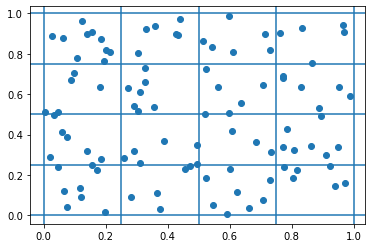

In [31]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
numBins=5
bins=np.linspace(0.0,1.0,numBins)
x=np.random.random_sample(100)
y=np.random.random_sample(100)
vx=np.random.random_sample(100)
vy=np.random.random_sample(100)
plt.scatter(x,y)
for bin in bins:
    plt.axvline(x=bin)
    plt.axhline(y=bin)
plt.show()

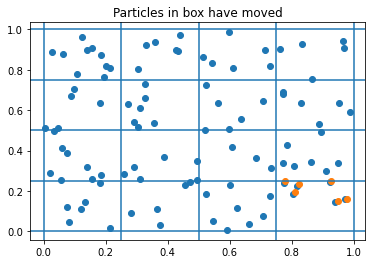

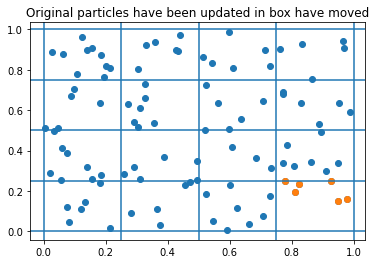

In [54]:
edgex=np.digitize(x,bins)
edgey=np.digitize(y,bins)
boxLoc=(4,1)
def func(c):
assert 1<=boxLoc[0]<=numBins and 1<=boxLoc[1]<=numBins
subIndices=np.logical_and(edgex==boxLoc[0],edgey==boxLoc[1])
xSub=x[subIndices]
ySub=y[subIndices]
vxSub=vx[subIndices]
vySub=vy[subIndices]

xSub=xSub+vxSub*1e-2
ySub=ySub+vySub*1e-2
plt.title("Particles in box have moved")
plt.scatter(x,y)
plt.scatter(xSub,ySub) #new positions
for bin in bins:
    plt.axvline(x=bin)
    plt.axhline(y=bin)
plt.show()
x[subIndices]=xSub #update the old coorinates
y[subIndices]=ySub
plt.title("Original particles have been updated in box have moved")
plt.scatter(x,y)
plt.scatter(xSub,ySub) #new positions
for bin in bins:
    plt.axvline(x=bin)
    plt.axhline(y=bin)
plt.show()

In [55]:
binCoords=np.asarray(np.meshgrid(bins,bins)).T.reshape(-1,2)
binCoords

array([[0.  , 0.  ],
       [0.  , 0.25],
       [0.  , 0.5 ],
       [0.  , 0.75],
       [0.  , 1.  ],
       [0.25, 0.  ],
       [0.25, 0.25],
       [0.25, 0.5 ],
       [0.25, 0.75],
       [0.25, 1.  ],
       [0.5 , 0.  ],
       [0.5 , 0.25],
       [0.5 , 0.5 ],
       [0.5 , 0.75],
       [0.5 , 1.  ],
       [0.75, 0.  ],
       [0.75, 0.25],
       [0.75, 0.5 ],
       [0.75, 0.75],
       [0.75, 1.  ],
       [1.  , 0.  ],
       [1.  , 0.25],
       [1.  , 0.5 ],
       [1.  , 0.75],
       [1.  , 1.  ]])